**Wymagane pakiety:**
- `matplotlib`
- `sortedcontainers`

# Inicjalizacja

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import sortedcontainers

import functools, math, csv, queue
from enum import Enum

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["lines.marker"] = ""
plt.rcParams["lines.markersize"] = 5

EPSILON = 10 ** -10
EPSILON_SQRT = 10 ** -5

# Funkcje pomocnicze

In [2]:
def prepPlot():
    plt.close()
    plt.axis("equal")
    
def unzip(tuplelist):
    if (len(tuplelist) > 0):
        return tuple(map(list, zip(*tuplelist)))
    else:
        return ([], [])
    
def distSqr(p1, p2):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2

def detOwn3(p0, p1, p2):
    return p0[0] * p1[1] + p1[0] * p2[1] + p2[0] * p0[1] - p2[0] * p1[1] - p1[0] * p0[1] - p0[0] * p2[1]
    
class Dir(Enum):
    CW, COLL, CCW = range(-1, 2)
    
    def getDir(p0, p1, p2):
        det = detOwn3(p0, p1, p2)

        if det < -EPSILON:
            return Dir.CW
        elif det <= EPSILON:
            return Dir.COLL
        else:
            return Dir.CCW

def signum(x):
    if x < 0:
        return -1
    elif x == 0:
        return 0
    else:
        return 1

def higherOnLeftCmp(p1, p2):
    return signum(p2[1] - p1[1] if p1[1] != p2[1] else p1[0] - p2[0])

# Zapis do `.csv`

In [3]:
def saveToCsv(segments, filename):
    with open(filename, 'w', newline="") as f:
        csvwriter = csv.writer(f)
        csvwriter.writerow(("x1", "y1", "x2", "y2"))
        for p1, p2 in segments:
            csvwriter.writerow((p1[0], p1[1], p2[0], p2[1]))

# Odczyt z `.csv`

In [4]:
def readFromCsv(filename):
    with open(filename, newline="") as f:
        csvreader = csv.reader(f)
        readLines = list(csvreader)
        if len(readLines) > 0:
            return list(map(lambda line: ((float(line[0]), float(line[1])), (float(line[2]), float(line[3]))), readLines[1:]))
        else:
            return []

# Tworzenie odcinków

### Aby uruchomić edytor należy wywołać komórkę z kodem:
```python
%matplotlib notebook
SegmentsEditor()
```

In [5]:
class SegmentsEditor:
    def __init__(self):
        plt.close()
        self.fig, self.ax = plt.subplots()
        self.fig.canvas.set_window_title("SegmentsEditor")
        plt.subplots_adjust(bottom=0.2)
        
        self.reinit()
        
        self.filename = "file.csv"
        
        self.bpe = self.fig.canvas.mpl_connect("button_press_event", self.onclick)
        
        self.bClear = mpl.widgets.Button(plt.axes([0.15, 0.05, 0.1, 0.075]), "Clear")
        self.bClearE = self.bClear.on_clicked(self.clear)
        
        self.bSave = mpl.widgets.Button(plt.axes([0.26, 0.05, 0.1, 0.075]), "Save")
        self.bSaveE = self.bSave.on_clicked(self.save)
        
        self.tFilename = mpl.widgets.TextBox(plt.axes([0.47, 0.05, 0.43, 0.075]), "Filename", initial=self.filename)
        self.tFilenameE = self.tFilename.on_text_change(self.onchange)
        
    def clearAx(self):
        self.ax.clear()
        self.ax.set_xlim((-10, 10))
        self.ax.set_ylim((-10, 10))
        
    def reinit(self):
        self.segments = []
        self.firstPoint = None
        self.clearAx()
        
    def onclick(self, event):
        x, y = event.xdata, event.ydata
        
        points = []
        for segment in self.segments:
            points.append(segment[0])
            points.append(segment[1])
        points.append((x, y))
        
        if self.firstPoint is None:
            self.firstPoint = (x, y)
        else:
            points.append(self.firstPoint)
            self.segments.append((self.firstPoint, (x, y)))
            self.firstPoint = None
        
        self.clearAx()    
        
        xPoints, yPoints = unzip(points)
        self.ax.scatter(xPoints, yPoints, color="black")
        
        for segment in self.segments:
            self.ax.plot([segment[0][0], segment[1][0]], [segment[0][1], segment[1][1]], color="black")

        
    def onchange(self, event):
        self.filename = event
        
    def clear(self, event):
        self.reinit()
        
    def save(self, event):
        saveToCsv(self.segments, self.filename)
        self.reinit()

# Struktury użyte w algorytmach

In [7]:
class Broom:
    def __init__(self):
        self.x = None

@functools.total_ordering
class Segment:
    def __init__(self, p1, p2, broom):
        self.p1 = p1 if p1 <= p2 else p2
        self.p2 = p2 if p1 <= p2 else p1
        self.broom = broom
        
        # calculate slope
        x1, y1 = self.p1
        x2, y2 = self.p2
        self.a = (y1 - y2) / (x1 - x2)
        self.b = y1 - self.a * x1
        
    def calcY(self):
        res = None
        if self.broom.x == self.p1[0]:
            res = self.p1[1]
        elif self.broom.x == self.p2[0]:
            res = self.p2[1]
        else:
            res = self.a * self.broom.x + self.b

        return round(res, 10)
    
    def onSegment(self, p):
        xi, yi = self.p1
        xj, yj = self.p2
        xk, yk = p
        
        return min(xi, xj) < xk < max(xi, xj) and min(yi, yj) < yk < max(yi, yj)
    
    def intersects(self, other):
        p1, p2, p3, p4 = self.p1, self.p2, other.p1, other.p2
        
        d1 = Dir.getDir(p3, p4, p1)
        d2 = Dir.getDir(p3, p4, p2)
        d3 = Dir.getDir(p1, p2, p3)
        d4 = Dir.getDir(p1, p2, p4)
        
        if (((d1 == Dir.CCW and d2 == Dir.CW) or (d1 == Dir.CW and d2 == Dir.CCW)) and 
            ((d3 == Dir.CCW and d4 == Dir.CW) or (d3 == Dir.CW and d4 == Dir.CCW))):
            a1, a2, b1, b2 = self.a, other.a, self.b, other.b
            
            crossX = (b2 - b1) / (a1 - a2)
            crossY = self.a * crossX + self.b
            
            return (crossX, crossY)
        
        if d1 == Dir.COLL and other.onSegment(p1):
            return p1
        
        if d2 == Dir.COLL and other.onSegment(p2):
            return p2
        
        if d3 == Dir.COLL and self.onSegment(p3):
            return p3
        
        if d4 == Dir.COLL and self.onSegment(p4):
            return p4
        
        return None
    
    def __repr__(self):
        return f"<{self.p1}, {self.p2}>"
        
    def __eq__(self, other):
        return self.calcY() == other.calcY()
    
    def __lt__(self, other):
        return self.calcY() < other.calcY()

    def equalPoints(self, other):
        return (self.p1, self.p2) == (other.p1, other.p2)

class EventType(int, Enum):
    START, CROSS, END = range(3)

@functools.total_ordering
class Event:
    def __init__(self, eventType, p, seg, seg2=None):
        self.eventType = eventType
        self.p = p
        self.seg = seg
        self.seg2 = seg2
        
    def __eq__(self, other):
        return self.p == other.p and self.eventType == other.eventType
    
    def __lt__(self, other):
        if self.p[0] != other.p[0]:
            return self.p[0] < other.p[0]
        
        if self.eventType != other.eventType:
            return self.eventType < other.eventType
        
        return self.p[1] < other.p[1]

# Wszystkie przecięcia

In [24]:
def findIntersections(segments):
    broom = Broom()
    eventQueue = queue.PriorityQueue()
    segmentSet = sortedcontainers.SortedList()
    intersections = []
    
    for segment in segments:
        segWrapper = Segment(segment[0], segment[1], broom)
        
        eventQueue.put(Event(EventType.START, segWrapper.p1, segWrapper))
        eventQueue.put(Event(EventType.END, segWrapper.p2, segWrapper))
    
    def checkForIntersect(seg1, seg2):
        crossP = seg1.intersects(seg2)
        if crossP is not None:
            intersections.append((crossP, (seg1.p1, seg1.p2), (seg2.p1, seg2.p2)))
            
            firstEvt = eventQueue.get()
            if distSqr(firstEvt.p, crossP) > EPSILON_SQRT:
                if crossP[0] >= broom.x:
                    eventQueue.put(Event(EventType.CROSS, crossP, seg1, seg2))
            eventQueue.put(firstEvt)
            
    def getPred(seg):
        currIdx = segmentSet.index(seg)

        while not segmentSet[currIdx].equalPoints(seg):
            currIdx += 1
        
        predIdx = currIdx - 1

        return segmentSet[predIdx] if predIdx >= 0 else None
    
    def getSucc(seg):
        currIdx = segmentSet.index(seg)

        while not segmentSet[currIdx].equalPoints(seg):
            currIdx += 1

        succIdx = currIdx + 1

        return segmentSet[succIdx] if succIdx < len(segmentSet) else None

    def remove(seg):
        currIdx = segmentSet.index(seg)

        while not segmentSet[currIdx].equalPoints(seg):
            currIdx += 1

        del segmentSet[currIdx]
        
    while not eventQueue.empty():
        event = eventQueue.get()
        broom.x = event.p[0]
        
        if event.eventType == EventType.START:

            seg = event.seg
            
            segmentSet.add(seg)
            
            pred = getPred(seg)
            succ = getSucc(seg)

            
            if succ is not None:
                checkForIntersect(seg, succ)

            if pred is not None:
                checkForIntersect(seg, pred)

        elif event.eventType == EventType.END:
            seg = event.seg
            
            pred = getPred(seg)
            succ = getSucc(seg)
            
            remove(seg)

            if pred is not None and succ is not None:
                checkForIntersect(pred, succ)
        else:
            seg1, seg2 = event.seg, event.seg2
            remove(seg1)
            remove(seg2)
            
            if seg1.p1[1] < seg2.p1[1]:
                segmentSet.add(seg2)
                segmentSet.add(seg1)
                
                seg2Pred = getPred(seg2)
                seg1Succ = getSucc(seg1)

                if seg1Succ is not None:
                    checkForIntersect(seg1, seg1Succ)

                if seg2Pred is not None:
                    checkForIntersect(seg2, seg2Pred)
                    
            else:
                segmentSet.add(seg1)
                segmentSet.add(seg2)
                
                seg1Pred = getPred(seg1)
                seg2Succ = getSucc(seg2)

                if seg2Succ is not None:
                    checkForIntersect(seg2, seg2Succ)

                if seg1Pred is not None:
                    checkForIntersect(seg1, seg1Pred)
        
    return intersections

<IPython.core.display.Javascript object>


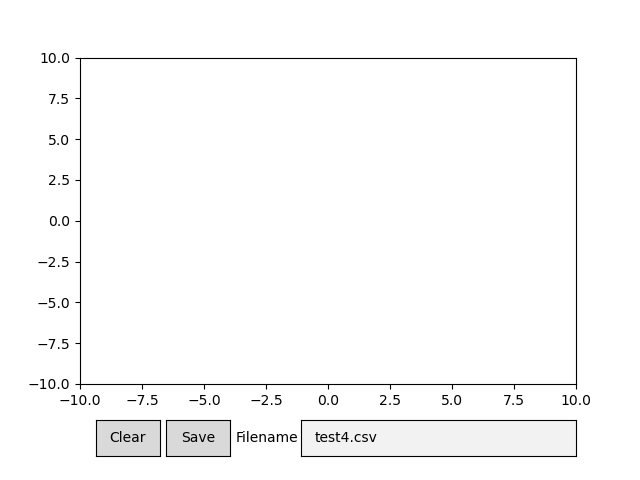

In [25]:
%matplotlib notebook
SegmentsEditor()

<IPython.core.display.Javascript object>


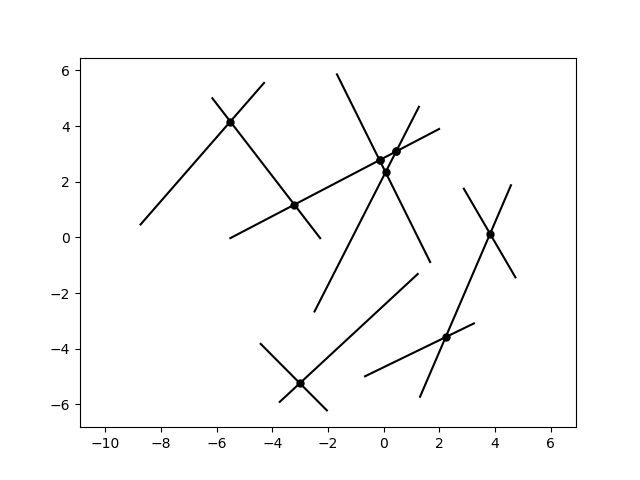

In [26]:
segments = readFromCsv("test4.csv")

points = [res[0] for res in findIntersections(segments)]

xPoints, yPoints = unzip(points)
prepPlot()
plt.scatter(xPoints, yPoints, color="black")

for segment in segments:
    plt.plot([segment[0][0], segment[1][0]], [segment[0][1], segment[1][1]], color="black")